In [1]:
from model import FreckerDataSet
from torch.utils.data import DataLoader, random_split
import torch
import torch.optim as optim
import torch.nn.functional as F
from model import MaskLoss, FreckersNet
from torch.optim.lr_scheduler import OneCycleLR

In [2]:
# file = r"C:\Users\lucyc\Desktop\freckers_data\P1.h5"
# file2 = r"C:\Users\lucyc\Desktop\freckers_data\P2.h5"
# dataset1 = FreckerDataSet(file_path=file)
# dataset2 = FreckerDataSet(file_path=file2)

#dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])

file_base_path = r"C:\Users\lucyc\Desktop\data"
versions = [str(i) for i in range(1, 2)]
datasets = [FreckerDataSet(file_base_path + "\\" + v + ".h5") for v in versions]

# # 合并两个数据集
dataset = torch.utils.data.ConcatDataset(datasets)

# dataset = FreckerDataSet(file_path=file)
# dataset = torch.utils.data.Subset(dataset, range(int(len(dataset) * (9/11)), len(dataset)))


# 按照顺序分割数据集
train_size = int(0.8 * len(dataset))  # 50% 用于训练
val_size = len(dataset) - train_size  # 50% 用于验证

# 使用 Subset 分割数据集
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

train_dataset, _ = random_split(train_dataset, [int(0.005 * len(train_dataset)), len(train_dataset) - int(0.1 * len(train_dataset))])
val_dataset, _ = random_split(val_dataset, [int(0.1 * len(val_dataset)), len(val_dataset) - int(0.1 * len(val_dataset))])
# 随机分割
# train_dataset, val_dataset = random_split(dataset, [int(0.5 * len(dataset)), len(dataset) - int(0.5 * len(dataset))])
# print(f"合并后的数据集大小: {len(train_dataset)}")

# # 定义训练集和验证集的大小
# train_size = int(0.8 * len(dataset))  # 80% 用于训练
# val_size = len(dataset) - train_size  # 20% 用于验证

# # 使用 random_split 分割数据集
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64
shuffle = True
num_workers = 1

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)

In [6]:
len(train_dataset)

21096

In [3]:
model = FreckersNet()

In [9]:
len(dataset)

80053

In [4]:
num_epochs = 10
stop_epoch = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)
# scheduler = OneCycleLR(
#     optimizer,
#     max_lr=0.0001,  # 最大学习率
#     steps_per_epoch=len(train_loader),
#     epochs=num_epochs,
#     pct_start=0.4  # warmup 的比例
# )
mask_loss = MaskLoss()

train_loss_record = []
eval_loss_record = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for gameboard, action_prob, value in train_loader:
        gameboard = gameboard.to(device)
        action_prob = action_prob.to(device)
        value = value.to(device)

        optimizer.zero_grad()
        p_action_prob, p_value = model(gameboard)
        # 计算双损失
        loss_img = mask_loss(p_action_prob, action_prob)
        loss_prob = F.mse_loss(p_value.view(-1), value)
        #loss_prob = 0
        total_loss = loss_img + loss_prob
        
        total_loss.backward()
        optimizer.step()
        #scheduler.step()
        train_loss += total_loss.item()
    
    train_loss /= len(train_loader)
    train_loss_record.append(train_loss)

    model.eval()
    eval_loss = 0.0
    with torch.no_grad():
        for gameboard, action_prob, value in val_loader:
            gameboard = gameboard.to(device)
            action_prob = action_prob.to(device)
            value = value.to(device)

            p_action_prob, p_value = model(gameboard)
            loss_img = mask_loss(p_action_prob, action_prob)
            loss_prob = F.mse_loss(p_value.view(-1), value)
            #loss_prob = 0
            total_loss = loss_img + loss_prob
            
            eval_loss += total_loss.item()
    
    eval_loss /= len(val_loader)
    eval_loss_record.append(eval_loss)

    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.8f}, Validation Loss: {eval_loss:.8f}")

    if epoch == stop_epoch:
        torch.save(model, "C:\\Users\\lucyc\\Desktop\\s2.pth")



c:\Users\lucyc\Desktop\freckers_zero\freckers\model.py:149: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_softmax = F.log_softmax(pred_main_flat[i][main_mask_flat[i]])


Epoch 1, Training Loss: 1.18147762, Validation Loss: 1.19928638
Epoch 2, Training Loss: 1.13789078, Validation Loss: 1.16522969
Epoch 3, Training Loss: 1.12382387, Validation Loss: 1.12652934
Epoch 4, Training Loss: 1.11336057, Validation Loss: 1.11317057
Epoch 5, Training Loss: 1.10304775, Validation Loss: 1.10785724
Epoch 6, Training Loss: 1.09711702, Validation Loss: 1.11595441
Epoch 7, Training Loss: 1.09567774, Validation Loss: 1.11190812
Epoch 8, Training Loss: 1.09039742, Validation Loss: 1.09515086
Epoch 9, Training Loss: 1.08493705, Validation Loss: 1.11511261
Epoch 10, Training Loss: 1.08404271, Validation Loss: 1.11211471


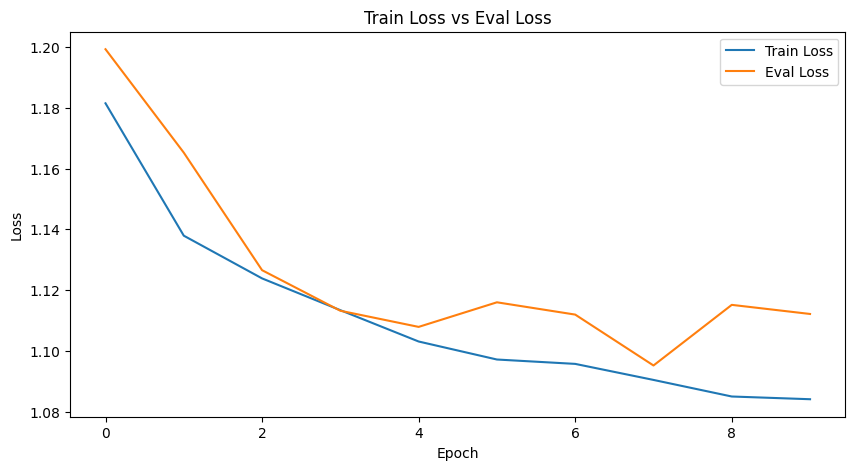

In [5]:
import matplotlib.pyplot as plt

# 绘制训练损失和验证损失的对比图
plt.figure(figsize=(10, 5))
plt.plot(train_loss_record, label='Train Loss')
plt.plot(eval_loss_record, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Eval Loss')
plt.legend()
plt.show()


In [2]:
import torch



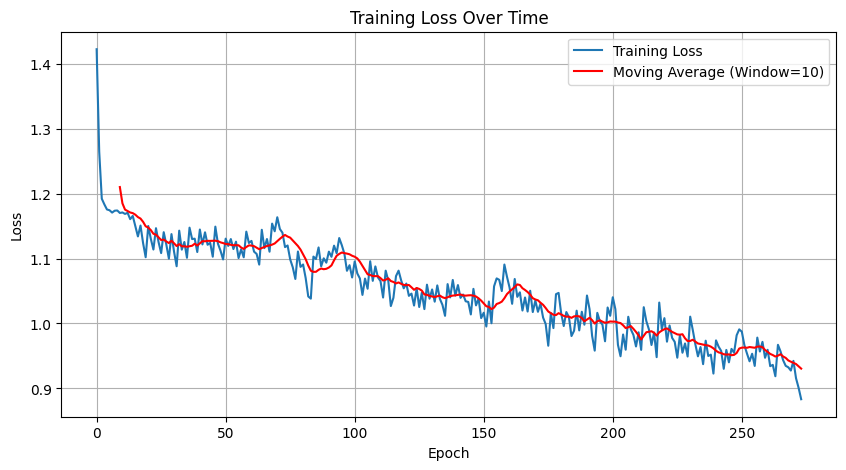

In [4]:
data = torch.load(r"/mnt/cdata/models/141.pth")
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(data["loss_rec"], label='Training Loss')

# 计算并绘制移动平均线
window_size = 10  # 设置移动平均窗口大小
moving_avg = np.convolve(data["loss_rec"], np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size-1, len(data["loss_rec"])), moving_avg, label=f'Moving Average (Window={window_size})', color='red')

plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
step = """
end within 63 steps
player: 0, Win: 1
end within 74 steps
player: 1, Win: 1
end within 66 steps
player: 1, Win: 1
end within 72 steps
player: 1, Win: 1
end within 70 steps
player: 1, Win: 1
end within 77 steps
player: 0, Win: 1
end within 82 steps
player: 1, Win: 1
end within 84 steps
player: 1, Win: 1
end within 66 steps
player: 1, Win: 1
end within 66 steps
player: 1, Win: 1
end within 71 steps
player: 0, Win: 1
end within 85 steps
player: 0, Win: 1
end within 72 steps
player: 1, Win: 1
end within 70 steps
player: 1, Win: 1
end within 69 steps
player: 0, Win: 1
end within 65 steps
player: 0, Win: 1
end within 90 steps
player: 1, Win: 1
end within 82 steps
player: 1, Win: 1
end within 74 steps
player: 1, Win: 1
end within 93 steps
player: 0, Win: 1
end within 64 steps
player: 1, Win: 1
end within 70 steps
player: 1, Win: 1
end within 72 steps
player: 1, Win: 1
end within 66 steps
player: 1, Win: 1
end within 72 steps
player: 1, Win: 1
end within 102 steps
player: 1, Win: 1
end within 93 steps
player: 0, Win: 1
end within 85 steps
player: 0, Win: 1
end within 94 steps
player: 1, Win: 1
end within 90 steps
player: 1, Win: 1
end within 74 steps
player: 1, Win: 1
end within 72 steps
player: 1, Win: 1
end within 77 steps
player: 0, Win: 1
end within 92 steps
player: 1, Win: 1
end within 87 steps
player: 0, Win: 1
end within 77 steps
player: 0, Win: 1
end within 74 steps
player: 1, Win: 1
end within 78 steps
player: 1, Win: 1
end within 102 steps
player: 1, Win: 1
end within 75 steps
player: 0, Win: 1
end within 86 steps
player: 1, Win: 1
end within 76 steps
player: 1, Win: 1
end within 69 steps
player: 0, Win: 1
end within 94 steps
player: 1, Win: 1
end within 84 steps
player: 1, Win: 1
end within 87 steps
player: 0, Win: 1
end within 74 steps
player: 1, Win: 1
end within 86 steps
player: 1, Win: 1
end within 88 steps
player: 1, Win: 1
end within 78 steps
player: 1, Win: 1
end within 78 steps
player: 1, Win: 1
end within 77 steps
player: 0, Win: 1
end within 68 steps
player: 1, Win: 1
end within 74 steps
player: 1, Win: 1
end within 69 steps
player: 0, Win: 1
end within 66 steps
player: 1, Win: 1
end within 75 steps
player: 0, Win: 1
end within 73 steps
player: 0, Win: 1
end within 93 steps
player: 0, Win: 1
end within 84 steps
player: 1, Win: 1
end within 78 steps
player: 1, Win: 1
end within 86 steps
player: 1, Win: 1
end within 81 steps
player: 0, Win: 1
end within 86 steps
player: 1, Win: 1
end within 76 steps
player: 1, Win: 1
end within 84 steps
player: 1, Win: 1
end within 82 steps
player: 1, Win: 1
end within 82 steps
player: 1, Win: 1
end within 72 steps
player: 1, Win: 1
end within 109 steps
player: 0, Win: 1
end within 72 steps
player: 1, Win: 1
end within 77 steps
player: 0, Win: 1
end within 88 steps
player: 1, Win: 1
end within 72 steps
player: 1, Win: 1
end within 85 steps
player: 0, Win: 1
end within 78 steps
player: 1, Win: 1
end within 76 steps
player: 1, Win: 1
end within 90 steps
player: 1, Win: 1
end within 98 steps
player: 1, Win: 1
end within 72 steps
player: 1, Win: 1
end within 74 steps
player: 1, Win: 1
end within 79 steps
player: 0, Win: 1
end within 75 steps
player: 0, Win: 1
end within 73 steps
player: 0, Win: 1
end within 77 steps
player: 0, Win: 1
end within 71 steps
player: 0, Win: 1
end within 70 steps
player: 1, Win: 1
end within 77 steps
player: 0, Win: 1
end within 64 steps
player: 1, Win: 1
end within 68 steps
player: 1, Win: 1
end within 81 steps
player: 0, Win: 1
end within 82 steps
player: 1, Win: 1
end within 75 steps
player: 0, Win: 1
end within 70 steps
player: 1, Win: 1
end within 72 steps
player: 1, Win: 1
end within 80 steps
player: 1, Win: 1
end within 62 steps
player: 1, Win: 1
end within 83 steps
player: 0, Win: 1
end within 80 steps
player: 1, Win: 1
end within 74 steps
player: 1, Win: 1
end within 68 steps
player: 1, Win: 1
end within 75 steps
player: 0, Win: 1
end within 88 steps
player: 1, Win: 1
end within 84 steps
player: 1, Win: 1
end within 86 steps
player: 1, Win: 1
end within 142 steps
player: 1, Win: 1
end within 78 steps
player: 1, Win: 1
end within 66 steps
player: 1, Win: 1
end within 72 steps
player: 1, Win: 1
end within 108 steps
player: 1, Win: 1
end within 84 steps
player: 1, Win: 1
end within 80 steps
player: 1, Win: 1
end within 78 steps
player: 1, Win: 1
end within 81 steps
player: 0, Win: 1
end within 87 steps
player: 0, Win: 1
end within 64 steps
player: 1, Win: 1
end within 82 steps
player: 1, Win: 1
end within 64 steps
player: 1, Win: 1
end within 60 steps
player: 1, Win: 1
end within 84 steps
player: 1, Win: 1
end within 64 steps
player: 1, Win: 1
end within 62 steps
player: 1, Win: 1
end within 85 steps
player: 0, Win: 1
end within 76 steps
player: 1, Win: 1
end within 86 steps
player: 1, Win: 1
end within 102 steps
player: 1, Win: 1
end within 82 steps
player: 1, Win: 1
end within 70 steps
player: 1, Win: 1
end within 78 steps
player: 1, Win: 1
end within 79 steps
player: 0, Win: 1
end within 83 steps
player: 0, Win: 1
end within 68 steps
player: 1, Win: 1
end within 76 steps
player: 1, Win: 1
end within 90 steps
player: 1, Win: 1
end within 250 steps
player: 1, Win: 0
end within 82 steps
player: 1, Win: 1
end within 88 steps
player: 1, Win: 1
end within 74 steps
player: 1, Win: 1
end within 76 steps
player: 1, Win: 1
end within 94 steps
player: 1, Win: 1
end within 87 steps
player: 0, Win: 1
end within 106 steps
player: 1, Win: 1
end within 83 steps
player: 0, Win: 1
end within 70 steps
player: 1, Win: 1
end within 111 steps
player: 0, Win: 1
end within 60 steps
player: 1, Win: 1
end within 82 steps
player: 1, Win: 1
end within 90 steps
player: 1, Win: 1
end within 70 steps
player: 1, Win: 1
end within 72 steps
player: 1, Win: 1
end within 70 steps
player: 1, Win: 1
end within 68 steps
player: 1, Win: 1
end within 84 steps
player: 1, Win: 1
end within 93 steps
player: 0, Win: 1
end within 96 steps
player: 1, Win: 1
end within 68 steps
player: 1, Win: 1
end within 72 steps
player: 1, Win: 1
end within 89 steps
player: 0, Win: 1
end within 91 steps
player: 0, Win: 1
end within 77 steps
player: 0, Win: 1
end within 70 steps
player: 1, Win: 1
end within 84 steps
player: 1, Win: 1
end within 72 steps
player: 1, Win: 1
end within 77 steps
player: 0, Win: 1
end within 70 steps
player: 1, Win: 1
end within 76 steps
player: 1, Win: 1
end within 70 steps
player: 1, Win: 1
end within 74 steps
player: 1, Win: 1
end within 69 steps
player: 0, Win: 1
end within 81 steps
player: 0, Win: 1
end within 104 steps
player: 1, Win: 1

"""

In [2]:
import re

def calculate_average_steps(input_text):
    # 使用正则表达式匹配所有"end within X steps"中的X
    steps = re.findall(r'end within (\d+) steps', input_text)
    
    # 将匹配到的字符串转换为整数
    steps = [int(step) for step in steps]
    
    # 计算均值
    if steps:
        average = sum(steps) / len(steps)
        return average
    else:
        return 0

calculate_average_steps(step)

80.11111111111111